In [1]:
import sys
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import os
import h5py
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
model=Sequential()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
xtrain_path=r"/content/drive/My Drive/srcnn/dataset/train/low_res"
ytrain_path=r"/content/drive/My Drive/srcnn/dataset/train/high_res"

In [4]:
low_res_path=os.listdir(xtrain_path)
high_res_path=os.listdir(ytrain_path)

In [ ]:
low_res_path[0]

'144.png'

In [5]:
x_train_path=[]
y_train_path=[]
for i in range(0,len(low_res_path)):
    x_train_path.append(xtrain_path+"/"+low_res_path[i])
    y_train_path.append(ytrain_path+"/"+high_res_path[i])

In [6]:
x_train_path= sorted(x_train_path)
y_train_path=sorted(y_train_path)

In [28]:
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale = 2


def prepare_data(_path):
    nums = _path.__len__()

    data = np.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=np.double)
    label = np.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=np.double)

    for i in _path:
        name = i
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (shape[1] / scale, shape[0] / scale))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        # produce Random_Crop random coordinate to crop training img
        Points_x = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
        Points_y = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)

        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label


In [29]:
BLOCK_STEP = 16
BLOCK_SIZE = 32


def prepare_crop_data(_path):
    nums = _path.__len__()

    data = []
    label = []

    for i in _path:
        name = i
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        shape = hr_img.shape

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (shape[1] // scale, shape[0] // scale))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        width_num = (shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        height_num = (shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
                hr = np.zeros((1, label_size, label_size), dtype=np.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = np.array(data, dtype=float)
    label = np.array(label, dtype=float)
    return data, label

In [30]:
def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()

In [31]:
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        train_data = np.transpose(data, (0, 2, 3, 1))
        train_label = np.transpose(label, (0, 2, 3, 1))
        return train_data, train_label

In [ ]:
traindata, trainlabel = prepare_crop_data(y_train_path)


In [8]:
srcnn=Sequential()
srcnn.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                 activation='relu', padding='valid', use_bias=True, input_shape=(None,None,1)))
srcnn.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
srcnn.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
adam = Adam(lr=0.0001)
srcnn.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
srcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_data = np.transpose(traindata, (0, 2, 3, 1))
train_label = np.transpose(trainlabel, (0, 2, 3, 1))
train_data.shape

(134260, 32, 32, 1)

In [ ]:
srcnn.fit(train_data,train_label,batch_size=128,epochs=250,validation_split=0.2)
history=srcnn.history

Epoch 1/250
840/840 [==============================] - 22s 26ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/250
840/840 [==============================] - 21s 25ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 3/250
840/840 [==============================] - 21s 25ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 4/250
840/840 [==============================] - 21s 25ms/step - loss: 9.9902e-04 - mean_squared_error: 9.9902e-04 - val_loss: 9.9367e-04 - val_mean_squared_error: 9.9367e-04
Epoch 5/250
840/840 [==============================] - 21s 25ms/step - loss: 9.8657e-04 - mean_squared_error: 9.8657e-04 - val_loss: 9.8306e-04 - val_mean_squared_error: 9.8306e-04
Epoch 6/250
840/840 [==============================] - 21s 25ms/step - loss: 9.7131e-04 - mean_squared_error: 9.7132e-04 - val_loss: 9.9685e-04

In [73]:
test_path="/content/drive/My Drive/srcnn/dataset/val/low_res/25.png"
img = cv2.imread(test_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
shape = img.shape

In [74]:
Y_img = cv2.resize(img[:, :, 0], (int(shape[1] / 2), int(shape[0] /2)), cv2.INTER_CUBIC)
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
img[:, :, 0] = Y_img
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)

Y = np.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
Y[0, :, :, 0] = Y_img.astype(float) / 255.
pre = srcnn.predict(Y, batch_size=1) * 255.
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)

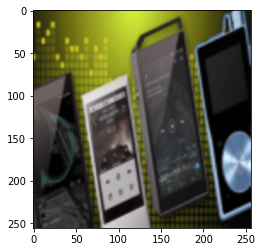

In [76]:
plt.imshow(cv2.imread(test_path))

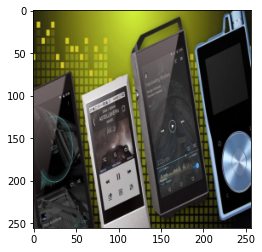

In [79]:
plt.imshow(img)

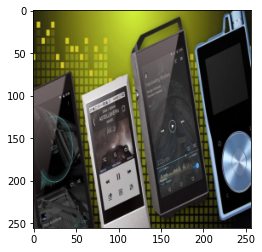

In [16]:
plt.imshow(cv2.imread("/content/drive/My Drive/srcnn/dataset/val/high_res/25.png"))